# Recommendation System - Merekomendasikan Judul Anime Berdasarkan Genrenya


### Deskripsi Proyek
Dalam upaya menghadapi persaingan yang semakin ketat di industri anime, sebuah perusahaan penyedia layanan streaming khusus anime berencana meningkatkan traffic dan retensi pengguna di platform mereka. Salah satu strategi yang diambil adalah dengan memanfaatkan teknologi Machine Learning untuk membangun sistem rekomendasi film yang lebih personal. Sistem ini akan menganalisis preferensi pengguna berdasarkan genre anime yang sering ditonton, lalu menyarankan judul-judul anime yang relevan dan menarik. Pendekatan ini diharapkan tidak hanya meningkatkan kepuasan pengguna, tetapi juga memperkuat posisi perusahaan di pasar industri anime yang terus berkembang.

## Import Library

In [2]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors



## Download Dataset

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d quanthan/top-15000-ranked-anime-dataset-update-to-32025

Dataset URL: https://www.kaggle.com/datasets/quanthan/top-15000-ranked-anime-dataset-update-to-32025
License(s): apache-2.0
  0% 0.00/9.27M [00:00<?, ?B/s]
100% 9.27M/9.27M [00:00<00:00, 890MB/s]


In [5]:
!unzip top-15000-ranked-anime-dataset-update-to-32025.zip

Archive:  top-15000-ranked-anime-dataset-update-to-32025.zip
  inflating: top_anime_dataset.csv   
  inflating: top_anime_dataset_v2.csv  


# Data Understanding

In [6]:
import pandas as pd

anime = pd.read_csv('/content/top_anime_dataset.csv')

print('Jumlah data judul anime: ', len(anime.anime_id.unique()))
print('Jumlah data ratings score: ', len(anime.score.unique()))

Jumlah data judul anime:  14965
Jumlah data ratings score:  344


## Univariate Exploratory Data (EDA)

Exploratory data analysis merupakan proses investigasi awal pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data. Teknik ini biasanya menggunakan bantuan statistik dan representasi grafis atau visualisasi.

In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        15000 non-null  int64  
 1   anime_url       15000 non-null  object 
 2   image_url       15000 non-null  object 
 3   name            15000 non-null  object 
 4   english_name    8355 non-null   object 
 5   japanese_names  14953 non-null  object 
 6   score           15000 non-null  float64
 7   genres          13397 non-null  object 
 8   synopsis        14527 non-null  object 
 9   type            14999 non-null  object 
 10  episodes        14885 non-null  float64
 11  premiered       4686 non-null   object 
 12  producers       9568 non-null   object 
 13  studios         12617 non-null  object 
 14  source          15000 non-null  object 
 15  duration        15000 non-null  object 
 16  rating          14932 non-null  object 
 17  rank            11921 non-null 

In [8]:
anime.head()

,anime_id,anime_url,image_url,name,english_name,japanese_names,score,genres,synopsis,type,...,producers,studios,source,duration,rating,rank,popularity,favorites,scored_by,members
0,52991,https://myanimelist.net/anime/52991/Sousou_no_...,https://cdn.myanimelist.net/images/anime/1015/...,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,9.31,"Adventure, Drama, Fantasy",During their decade-long quest to defeat the D...,TV,...,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,1.0,160,63200,603520,1035677
1,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1208/...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,9.10,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,...,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24 min per ep,R - 17+ (violence & profanity),2.0,3,231928,2196353,3483268
2,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/1935/...,Steins;Gate,Steins;Gate,STEINS;GATE,9.07,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,...,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24 min per ep,PG-13 - Teens 13 or older,3.0,14,194507,1449844,2667979
3,60022,https://myanimelist.net/anime/60022/One_Piece_...,https://cdn.myanimelist.net/images/anime/1455/...,One Piece Fan Letter,NaN,ONE PIECE FAN LETTER,9.06,"Action, Adventure, Fantasy",Although the golden age of piracy is about to ...,TV Special,...,NaN,Toei Animation,Light novel,24 min,PG-13 - Teens 13 or older,4.0,2350,1970,68977,91278
4,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,9.05,"Action, Drama, Suspense",Seeking to restore humanity's diminishing hope...,TV,...,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23 min per ep,R - 17+ (violence & profanity),5.0,21,60500,1671010,2407861


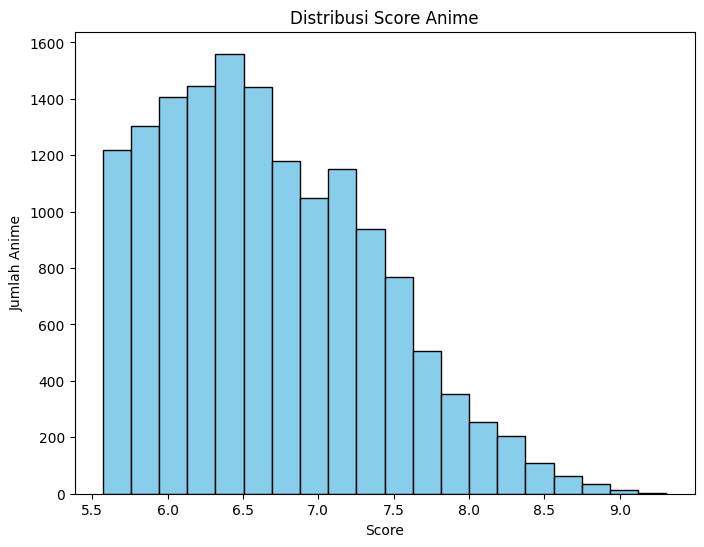

In [9]:
# prompt: make a code to visualisasi fitur numerik

# Visualisasi fitur numerik (contoh: score)
plt.figure(figsize=(8, 6))
plt.hist(anime['score'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Score Anime')
plt.xlabel('Score')
plt.ylabel('Jumlah Anime')
plt.show()


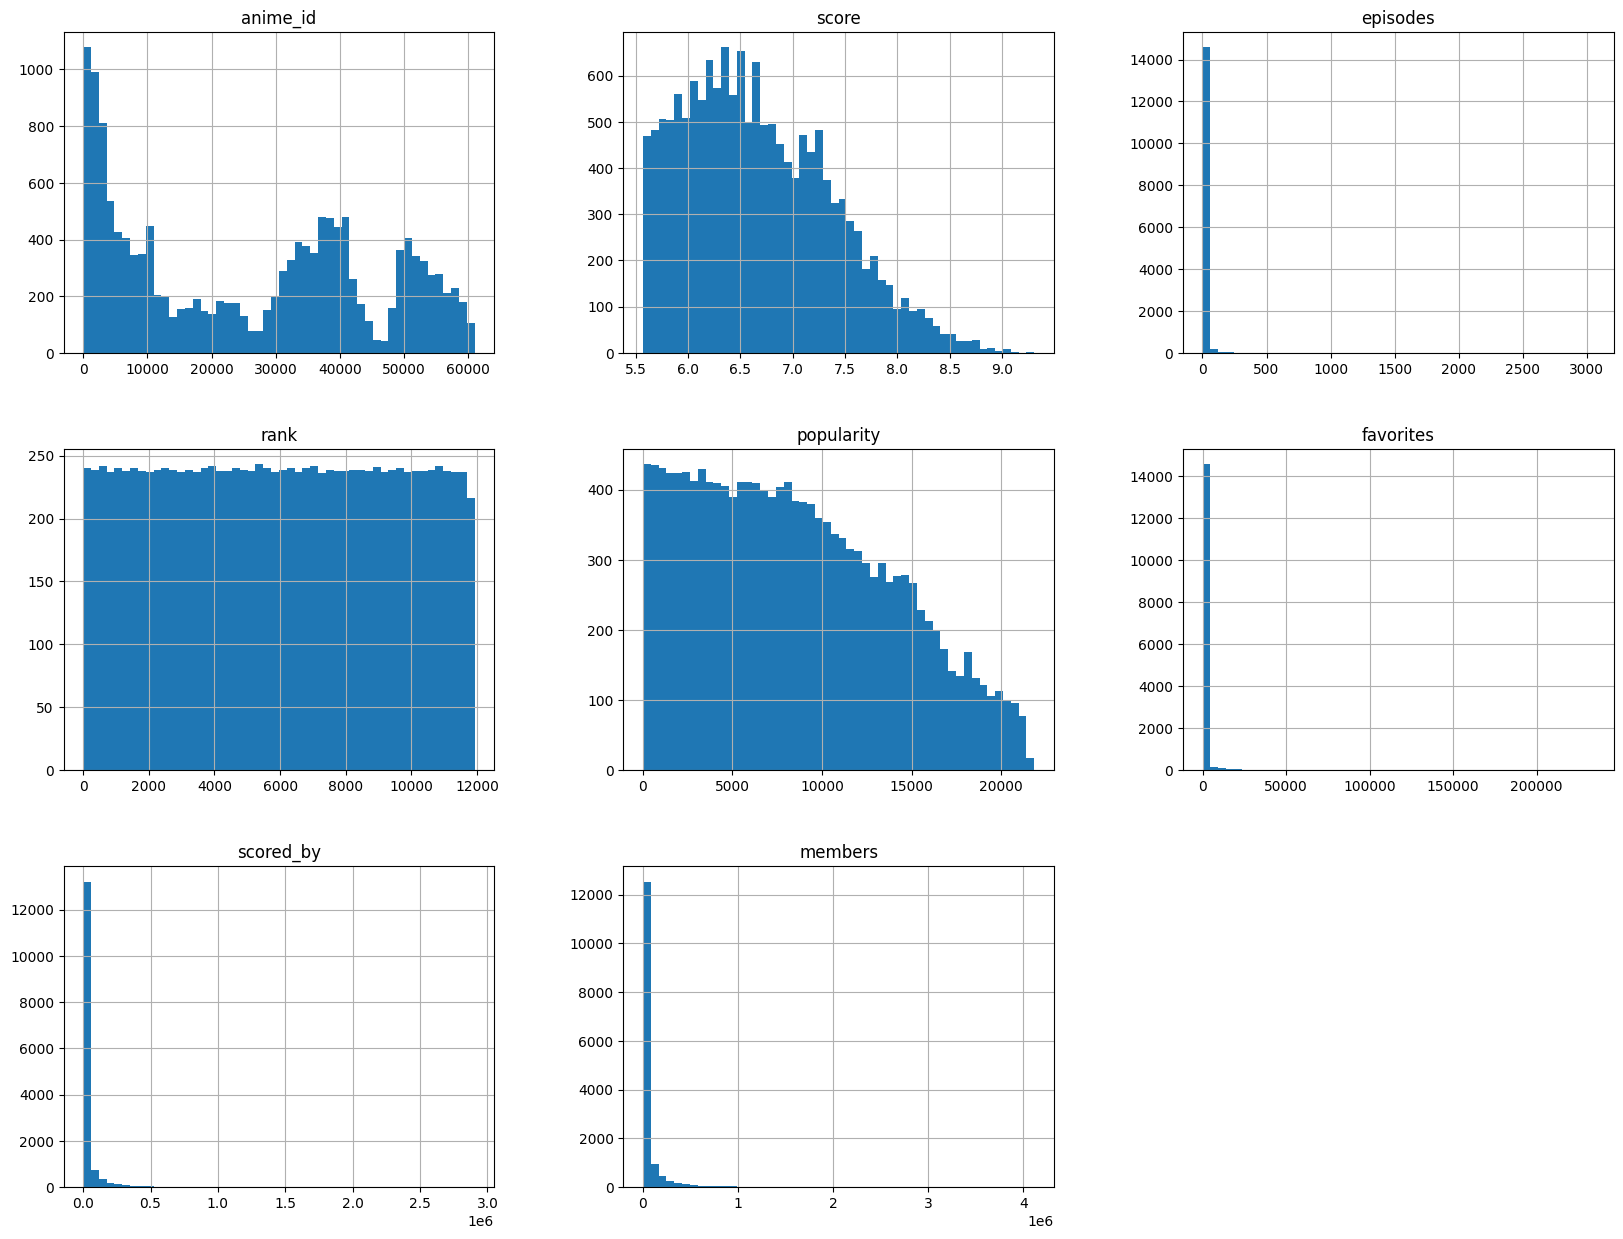

In [10]:
# visualisasi fitur numerik yang ada di dataset rating
anime.hist(bins=50, figsize=(20,15))
plt.show()


 Menampilkan Jumlah Nilai Kosong (NaN) di Setiap Kolom dari DataFrame anime.

In [11]:
anime.isnull().sum()

,0
anime_id,0
anime_url,0
image_url,0
name,0
english_name,6645
japanese_names,47
score,0
genres,1603
synopsis,473
type,1


Terdapat data yang duplikat pada kolom english_name, japanese_names, genres, sypnosis, type, episodes, premiered, producers, studios, rank

In [12]:
print(f'Jumlah data anime yang duplikat: {anime.duplicated().sum()}')

Jumlah data anime yang duplikat: 35


Menjadikan dataset hanya memiliki kolom anime_id, genres, score, type, dan studios

In [13]:
# Keep only the desired columns
columns_to_keep = ['anime_id', 'name', 'genres', 'score', 'type', 'studios']
anime = anime[columns_to_keep]

# Display the first few rows of the filtered DataFrame
print(anime.head())

   anime_id                                name  \
0     52991                   Sousou no Frieren   
1      5114    Fullmetal Alchemist: Brotherhood   
2      9253                         Steins;Gate   
3     60022                One Piece Fan Letter   
4     38524  Shingeki no Kyojin Season 3 Part 2   

                              genres  score        type         studios  
0          Adventure, Drama, Fantasy   9.31          TV        Madhouse  
1  Action, Adventure, Drama, Fantasy   9.10          TV           Bones  
2            Drama, Sci-Fi, Suspense   9.07          TV       White Fox  
3         Action, Adventure, Fantasy   9.06  TV Special  Toei Animation  
4            Action, Drama, Suspense   9.05          TV      Wit Studio  


# Data preparation

In [14]:
anime.head()

,anime_id,name,genres,score,type,studios
0,52991,Sousou no Frieren,"Adventure, Drama, Fantasy",9.31,TV,Madhouse
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",9.10,TV,Bones
2,9253,Steins;Gate,"Drama, Sci-Fi, Suspense",9.07,TV,White Fox
3,60022,One Piece Fan Letter,"Action, Adventure, Fantasy",9.06,TV Special,Toei Animation
4,38524,Shingeki no Kyojin Season 3 Part 2,"Action, Drama, Suspense",9.05,TV,Wit Studio


### Splitting data genre from dataset

Membagi dataset berdasarkan genre

In [15]:
animes_new = anime.assign(genres=anime.genres.str.split('|')).explode('genres').reset_index(drop=True)
animes_new

,anime_id,name,genres,score,type,studios
0,52991,Sousou no Frieren,"Adventure, Drama, Fantasy",9.31,TV,Madhouse
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",9.10,TV,Bones
2,9253,Steins;Gate,"Drama, Sci-Fi, Suspense",9.07,TV,White Fox
3,60022,One Piece Fan Letter,"Action, Adventure, Fantasy",9.06,TV Special,Toei Animation
4,38524,Shingeki no Kyojin Season 3 Part 2,"Action, Drama, Suspense",9.05,TV,Wit Studio
...,...,...,...,...,...,...
14995,1595,Inma Daitoshi: Beast City,Hentai,5.57,OVA,C and R
14996,49943,Cosplay Change: Pure-kei Joshidaisei no Kiken ...,Hentai,5.57,OVA,Mousou Senka
14997,38812,Botsuraku,NaN,5.57,Music,NaN
14998,38914,Papa no March,NaN,5.57,Music,NaN


### Menangani missing value

Menampilkan jumlah nilai yang hilang (NaN) di setiap kolom dari DataFrame animes_new.

In [16]:
animes_new.isnull().sum()


,0
anime_id,0
name,0
genres,1603
score,0
type,1
studios,2383


Menghapus semua baris yang mengandung nilai kosong (NaN) dari DataFrame animes_new, dan menyimpannya ke variabel animes.

In [17]:
# Membuang data yang kosong
animes = animes_new.dropna()
animes

,anime_id,name,genres,score,type,studios
0,52991,Sousou no Frieren,"Adventure, Drama, Fantasy",9.31,TV,Madhouse
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",9.10,TV,Bones
2,9253,Steins;Gate,"Drama, Sci-Fi, Suspense",9.07,TV,White Fox
3,60022,One Piece Fan Letter,"Action, Adventure, Fantasy",9.06,TV Special,Toei Animation
4,38524,Shingeki no Kyojin Season 3 Part 2,"Action, Drama, Suspense",9.05,TV,Wit Studio
...,...,...,...,...,...,...
14989,49922,Rape! Rape! Rape! DVD-Box Special,Hentai,5.57,Special,Anime Antenna Iinkai
14990,9211,Shikatte Ingo: Misaki Shunin no Buka Kyouiku-hen,Hentai,5.57,OVA,Studio Boogie Nights
14991,4379,Inmu: Ikenie no Utage,"Supernatural, Hentai",5.57,OVA,PP Project
14995,1595,Inma Daitoshi: Beast City,Hentai,5.57,OVA,C and R


Menyortir DataFrame animes berdasarkan kolom anime_id secara menaik (dari angka kecil ke besar).



In [18]:
# Menampilkan data dan mengurutkannya berdasarkan movieId
animes = animes.sort_values('anime_id', ascending=True)
animes

,anime_id,name,genres,score,type,studios
48,1,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,TV,Sunrise
218,5,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",8.38,Movie,Bones
382,6,Trigun,"Action, Adventure, Sci-Fi",8.22,TV,Madhouse
3361,7,Witch Hunter Robin,"Action, Drama, Mystery, Supernatural",7.24,TV,Sunrise
5128,8,Bouken Ou Beet,"Action, Adventure, Fantasy",6.93,TV,Toei Animation
...,...,...,...,...,...,...
4214,60662,Neko ni Naritai Tamagawa-kun,"Boys Love, Comedy",7.09,TV Special,Aeonium
4215,60662,Neko ni Naritai Tamagawa-kun,"Boys Love, Comedy",7.09,TV Special,Aeonium
9800,60775,Blue Lock Additional Time,"Comedy, Sports",6.29,ONA,8bit
8964,60790,"Luffy, Law",Action,6.39,Movie,Toei Animation


In [19]:
len(animes.anime_id.unique())


11926

In [20]:
print('Genres: ', animes.genres.unique())

Genres:  ['Action, Award Winning, Sci-Fi' 'Action, Sci-Fi'
 'Action, Adventure, Sci-Fi' 'Action, Drama, Mystery, Supernatural'
 'Action, Adventure, Fantasy' 'Sports' 'Comedy, Drama, Romance'
 'Comedy, Slice of Life, Sports' 'Action, Drama'
 'Drama, Mystery, Suspense' 'Comedy, Romance'
 'Action, Adventure, Comedy, Sci-Fi, Ecchi'
 'Avant Garde, Drama, Mystery, Sci-Fi, Suspense' 'Action, Fantasy, Sci-Fi'
 'Comedy, Gourmet' 'Action, Drama, Sci-Fi'
 'Action, Avant Garde, Award Winning, Drama, Sci-Fi, Suspense'
 'Action, Drama, Sci-Fi, Suspense'
 'Action, Avant Garde, Drama, Sci-Fi, Suspense'
 'Action, Adventure, Drama, Fantasy, Horror'
 'Action, Award Winning, Mystery, Sci-Fi, Suspense'
 'Action, Drama, Romance' 'Action, Comedy, Romance' 'Drama'
 'Action, Horror, Sci-Fi' 'Adventure, Fantasy, Mystery'
 'Comedy, Romance, Supernatural' 'Action, Drama, Romance, Supernatural'
 'Award Winning, Comedy, Drama, Sci-Fi'
 'Action, Adventure, Fantasy, Horror, Sci-Fi' 'Adventure, Fantasy, Sci-Fi'
 'Acti

### Menghapus data duplikat

In [21]:
# Menghapus data duplikat pada variabel preparation
animes = animes.drop_duplicates('anime_id')
animes

,anime_id,name,genres,score,type,studios
48,1,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,TV,Sunrise
218,5,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",8.38,Movie,Bones
382,6,Trigun,"Action, Adventure, Sci-Fi",8.22,TV,Madhouse
3361,7,Witch Hunter Robin,"Action, Drama, Mystery, Supernatural",7.24,TV,Sunrise
5128,8,Bouken Ou Beet,"Action, Adventure, Fantasy",6.93,TV,Toei Animation
...,...,...,...,...,...,...
12397,60629,"""1-punkan dake Furete mo Ii yo..."" Share House...",Hentai,5.95,ONA,Studio LEO
4214,60662,Neko ni Naritai Tamagawa-kun,"Boys Love, Comedy",7.09,TV Special,Aeonium
9800,60775,Blue Lock Additional Time,"Comedy, Sports",6.29,ONA,8bit
8964,60790,"Luffy, Law",Action,6.39,Movie,Toei Animation


#### Mengonversi data series anime_id,name, dan genres menjadi bentuk list


In [22]:

# Mengonversi data series ‘anime_id’ menjadi bentuk list
anime_id = animes['anime_id'].tolist()

# Mengonversi data series 'name' menjadi bentuk list
anime_title = animes['name'].tolist()

# Mengonversi data series ‘genres’ menjadi bentuk list
anime_genre = animes['genres'].tolist()

print(len(anime_id))
print(len(anime_title))
print(len(anime_genre))

11926
11926
11926


# Model Development dengan Content Based Filtering


Content-Based Filtering adalah metode rekomendasi yang menggunakan informasi atau fitur dari item (seperti deskripsi, genre, atau atribut lainnya) untuk merekomendasikan item serupa.


### TF-IDF Vectorizer


Salah satu pendekatan populer adalah menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer, yang mengubah teks (misalnya, sinopsis film atau deskripsi produk) menjadi representasi numerik berdasarkan seberapa penting kata tersebut dalam dokumen tertentu dibandingkan seluruh koleksi.

In [23]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genre
tf.fit(animes['genres'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'avant', 'award', 'boys', 'comedy', 'drama',
       'ecchi', 'erotica', 'fantasy', 'fi', 'garde', 'girls', 'gourmet',
       'hentai', 'horror', 'life', 'love', 'mystery', 'of', 'romance',
       'sci', 'slice', 'sports', 'supernatural', 'suspense', 'winning'],
      dtype=object)

In [24]:

# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(animes['genres'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(11926, 27)

In [25]:
tfidf_matrix.todense()

matrix([[0.24903226, 0.        , 0.        , ..., 0.        , 0.        ,
         0.6088381 ],
        [0.48968206, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.42264976, 0.505015  , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.72832596, 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [26]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=animes.genres
).sample(12, axis=1).sample(10, axis=0)

,supernatural,boys,girls,action,mystery,suspense,award,of,love,gourmet,romance,sports
genres,,,,,,,,,,,,
"Comedy, Romance",0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.826152,0.0
Action,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"Action, Fantasy",0.000000,0.0,0.0,0.664635,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"Adventure, Fantasy",0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"Action, Adventure, Drama",0.000000,0.0,0.0,0.491086,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Action,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"Action, Adventure, Comedy, Supernatural",0.660104,0.0,0.0,0.411682,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"Fantasy, Romance",0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.778031,0.0
"Action, Comedy, Sci-Fi",0.000000,0.0,0.0,0.444030,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0



##Cosine Similiarity

Cosine Similarity adalah ukuran kemiripan antara dua vektor dalam ruang vektor berdimensi tinggi. Nilainya berkisar dari -1 hingga 1, tetapi dalam konteks TF-IDF dan rekomendasi, nilainya biasanya antara 0 dan 1, karena semua nilai dalam vektor TF-IDF adalah non-negatif.

In [27]:

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.50855908, 0.43894271, ..., 0.        , 0.24903226,
        0.        ],
       [0.50855908, 1.        , 0.86311057, ..., 0.        , 0.48968206,
        0.        ],
       [0.43894271, 0.86311057, 1.        , ..., 0.        , 0.42264976,
        0.36781554],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.24903226, 0.48968206, 0.42264976, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.36781554, ..., 0.        , 0.        ,
        1.        ]])

In [28]:

# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=animes['name'], columns=animes['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap nama anime
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (11926, 11926)


name,Zannen na Ikimono Jiten,Kono Aozora ni Yakusoku wo: Youkoso Tsugumi Ryou e,H2O: Footprints in the Sand,Doupo Cangqiong: San Nian Zhi Yue,Love Live! Sunshine!!
name,,,,,
Yuu☆Yuu☆Hakusho: Eizou Hakusho II,0.000000,0.000000,0.545164,0.351713,0.0
Hyakka Ryouran: Samurai Girls Specials,0.000000,0.000000,0.000000,0.000000,0.0
Qiang Shen Ji: Tegong Shijie Pian,0.000000,0.000000,0.000000,0.325460,0.0
Sinbad: Soratobu Hime to Himitsu no Shima,0.000000,0.000000,0.000000,0.000000,0.0
Joker Game: Kuroneko Yoru no Bouken,0.000000,0.000000,0.525332,0.000000,0.0
Yaoguai Mingdan,0.126570,0.616271,0.343801,0.665998,0.0
Shikioriori,0.000000,0.728022,0.766288,0.000000,0.0
Beelzebub: Hirotta Akachan wa Daimaou!?,0.135205,0.000000,0.487127,0.314270,0.0
Nuwa Chengzhang Riji,0.194315,0.000000,0.000000,0.570802,0.0


#Pengujian Anime Recommendation

In [29]:
def anime_recommendations(title, similarity_data=cosine_sim_df, items=animes[['name', 'genres']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Membuang movie_title agar nama film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)


## Result

In [30]:
# Melihat genre film yang akan diuji
anime_title = 'Sousou no Frieren'
animes[animes.name.eq(anime_title)]

,anime_id,name,genres,score,type,studios
0,52991,Sousou no Frieren,"Adventure, Drama, Fantasy",9.31,TV,Madhouse


In [31]:
anime_recommendations = anime_recommendations(anime_title)
anime_recommendations

,name,genres
0,Strange Dawn,"Adventure, Drama, Fantasy"
1,Kino no Tabi: The Beautiful World - The Animat...,"Adventure, Drama, Fantasy"
2,Hikari no Ou,"Adventure, Drama, Fantasy"
3,Kino no Tabi: The Beautiful World - Tou no Kun...,"Adventure, Drama, Fantasy"
4,Kaze wo Mita Shounen,"Adventure, Drama, Fantasy"
5,.hack//Roots,"Adventure, Drama, Fantasy"
6,Hikari no Ou 2nd Season,"Adventure, Drama, Fantasy"
7,Eien no Filena,"Adventure, Drama, Fantasy"
8,Grick no Bouken,"Adventure, Drama, Fantasy"
9,Madang-eul Naon Amtalg,"Adventure, Drama, Fantasy"


# Evaluation

### Metrik yang cocok dipakai untuk kasus content based filtering adalah Precision.


In [36]:
relevant_genres = {"Adventure", "Drama", "Fantasy"}  # gunakan set agar urutan tidak penting

# Fungsi untuk memeriksa kecocokan genre
def is_relevant(genres):
    genres_set = set(genres.split(', '))  # ubah string genre menjadi set
    return relevant_genres.issubset(genres_set)  # periksa apakah semua genre relevan ada dalam genres_set

# Tambahkan kolom apakah film relevan
anime_recommendations['is_relevant'] = anime_recommendations['genres'].apply(is_relevant)

# Hitung True Positives dan Total Recommended
true_positives = anime_recommendations['is_relevant'].sum()
total_recommended = len(anime_recommendations)

# Precision
precision = true_positives / total_recommended * 100
print(f"Precision: {precision:.2f}%")

Precision: 100.00%


Dari hasil diatas, nilai metriks precesion sebesar 100.00% untuk 10 anime yang direkomendasikan berdasarkan kemiripan genre.